In [1]:
# Import necessary libraries
import numpy as np
from glob import glob
import gc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as md
import pandas as pd
import sys
sys.path.append('../noise')

from fnal import Dataset
from utilities import plot_planes, plot_crate, plot_tpc, plot_wire_planes, plot_waveform, plot_ffts, plot_planes_new

# Set base path for saved figures
figure_path = '/Users/mueller/data/signoise_plots/'

# Set boolean flag for regenerating time series data.
REGEN_INPUTS = True

In [2]:
# Load the data.
input_path = '/Users/mueller/data/noise/epoch0/'
data = Dataset(f'/Users/mueller/data/noise/epoch0/run10265_new.root')

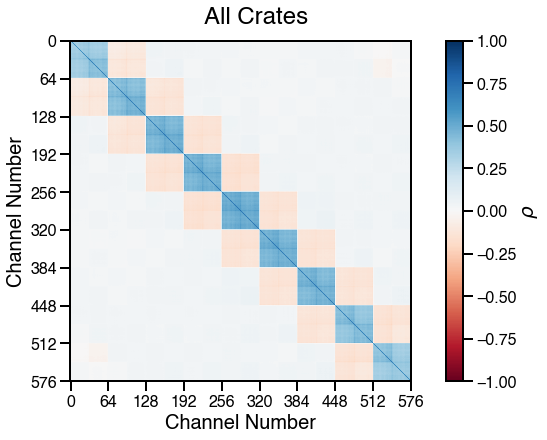

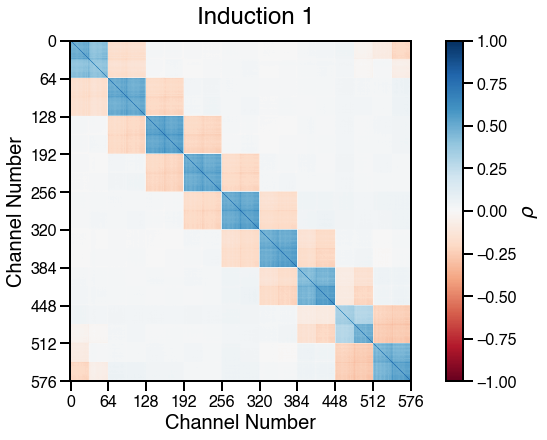

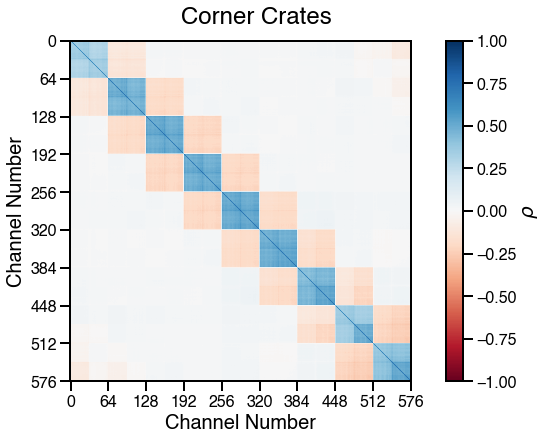

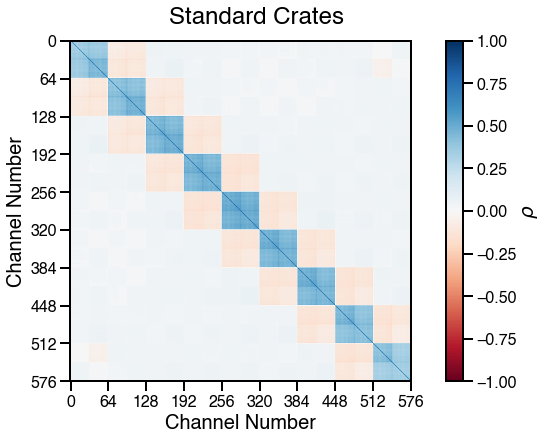

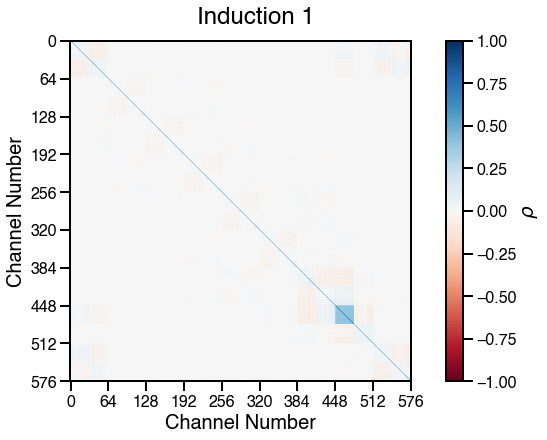

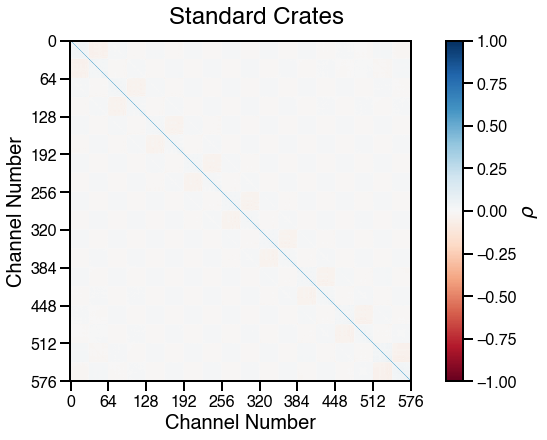

In [3]:
data.plot_correlation_matrix('all', save_path=f'{figure_path}noise/correlation_data_all.pdf')
data.plot_correlation_matrix('ind1', save_path=f'{figure_path}noise/correlation_data_ind1.pdf')
data.plot_correlation_matrix('corner', save_path=f'{figure_path}noise/correlation_data_corner.pdf')
data.plot_correlation_matrix('standard', save_path=f'{figure_path}noise/correlation_data_standard.pdf')
data.plot_correlation_matrix('ind1', save_path=f'{figure_path}noise/correlation_data_ind1_intrinsic.pdf', intrinsic=True)
data.plot_correlation_matrix('standard', save_path=f'{figure_path}noise/correlation_data_standard_intrinsic.pdf', intrinsic=True)

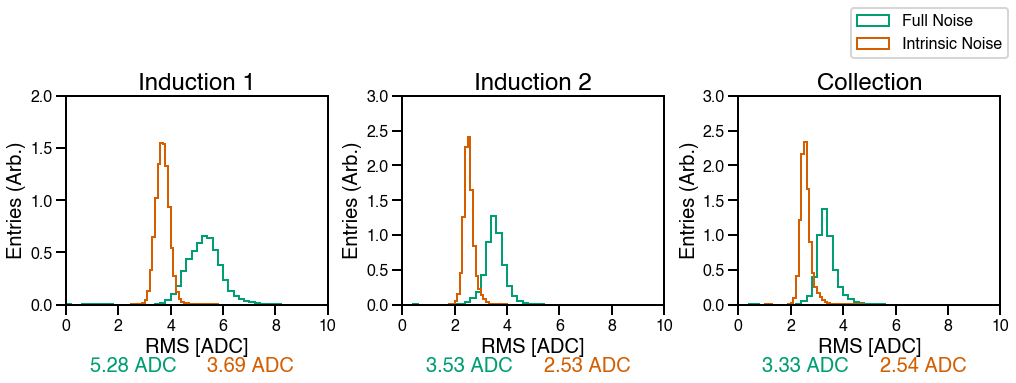

In [4]:
labels = ['Full Noise', 'Intrinsic Noise']
plot_planes_new(data, labels, ['!raw_rms', '!int_rms'], title=' ', normalize=True, cap=[2.0, 3.0, 3.0], wired_only=True, save_path=f'{figure_path}noise/absolute_data_noise.pdf')

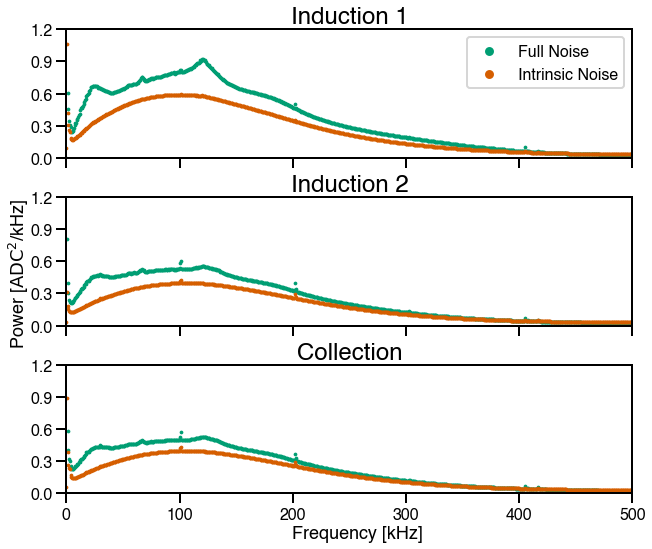

In [5]:
labels = ['Full Noise', 'Intrinsic Noise']
plot_ffts(data, labels, ['raw', 'int'], save_path=f'{figure_path}noise/ffts_data_noise.pdf')

In [6]:
montecarlo = Dataset(f'/Users/mueller/data/montecarlo_rev2.root')

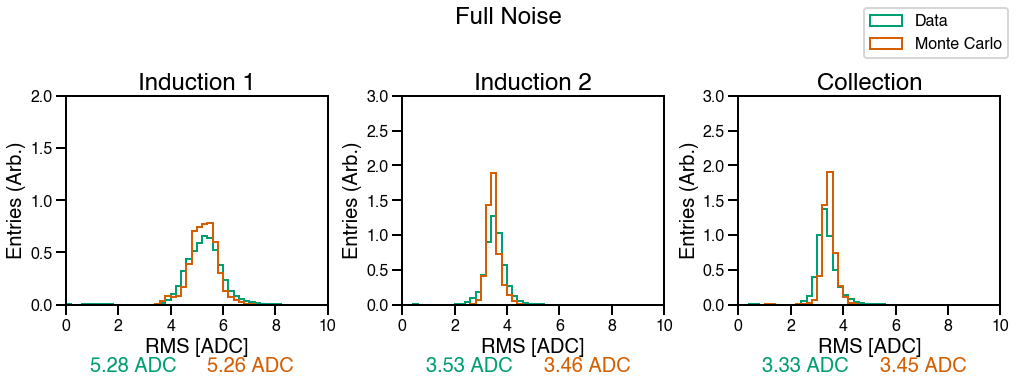

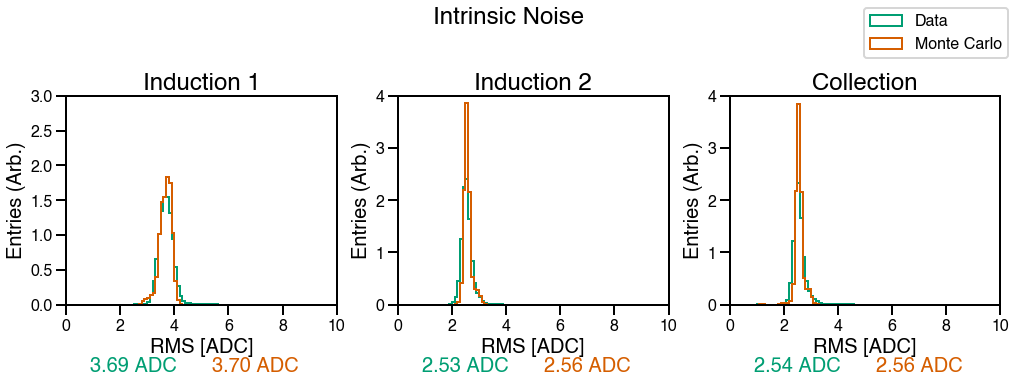

In [7]:
labels = ['Data', 'Monte Carlo']
plot_planes_new([data, montecarlo], labels, '!raw_rms', title='Full Noise', normalize=True, cap=[2.0, 3.0, 3.0], wired_only=True, save_path=f'{figure_path}noise/absolute_comparison_raw.pdf')
plot_planes_new([data, montecarlo], labels, '!int_rms', title='Intrinsic Noise', normalize=True, cap=[3.0, 4.0, 4.0], wired_only=True, save_path=f'{figure_path}noise/absolute_comparison_intrinsic.pdf')

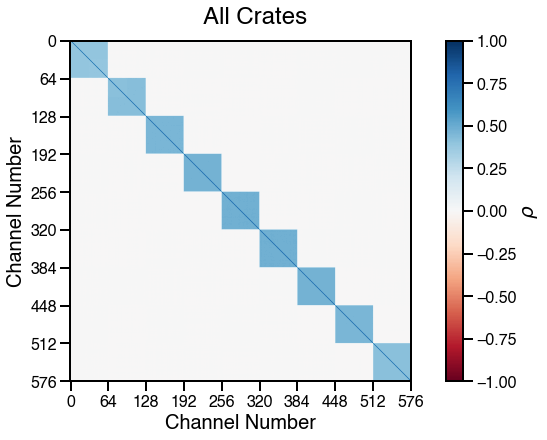

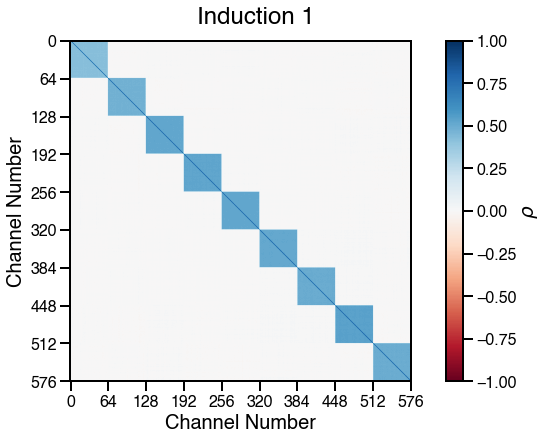

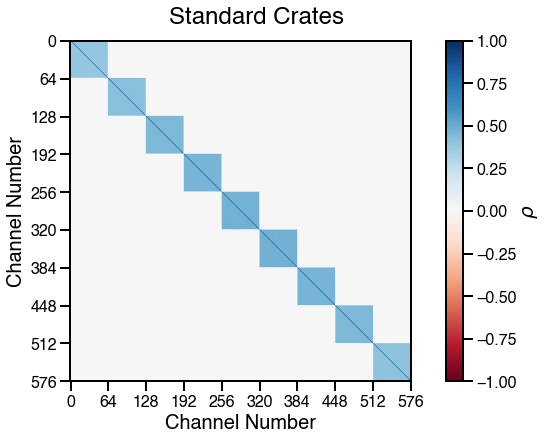

In [8]:
montecarlo.plot_correlation_matrix('all')#, save_path=f'{figure_path}noise/correlation_montecarlo_ind1.pdf')
montecarlo.plot_correlation_matrix('ind1', save_path=f'{figure_path}noise/correlation_montecarlo_ind1.pdf')
montecarlo.plot_correlation_matrix('standard', save_path=f'{figure_path}noise/correlation_montecarlo_standard.pdf')

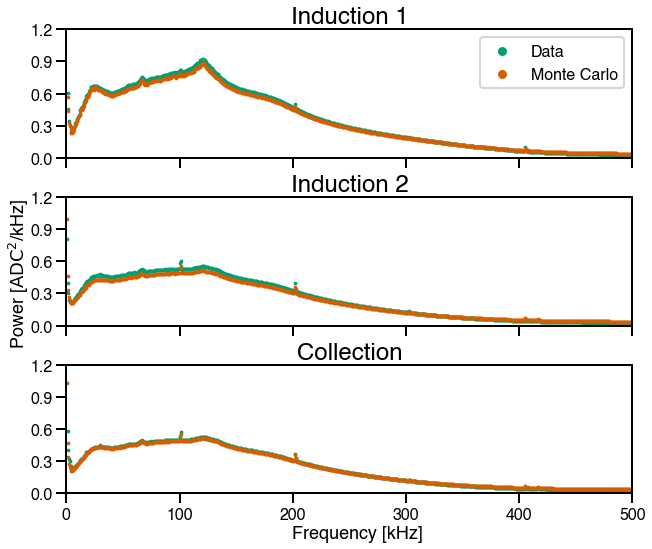

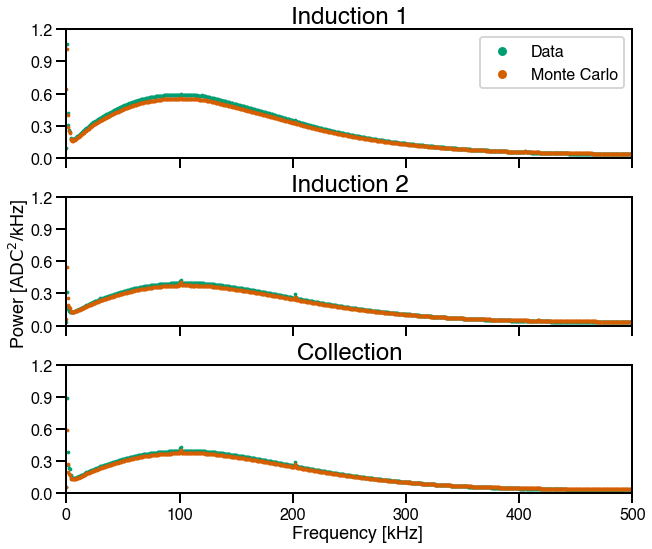

In [9]:
plot_ffts([data, montecarlo], labels, 'raw', save_path=f'{figure_path}noise/ffts_comparison_raw.pdf')
plot_ffts([data, montecarlo], labels, 'int', save_path=f'{figure_path}noise/ffts_comparison_intrinsic.pdf')

5.74 +/- 4.47%
3.62 +/- 1.12%
3.43 +/- 1.03%
3.92 +/- 1.24%
2.58 +/- 1.11%
2.62 +/- 0.68%


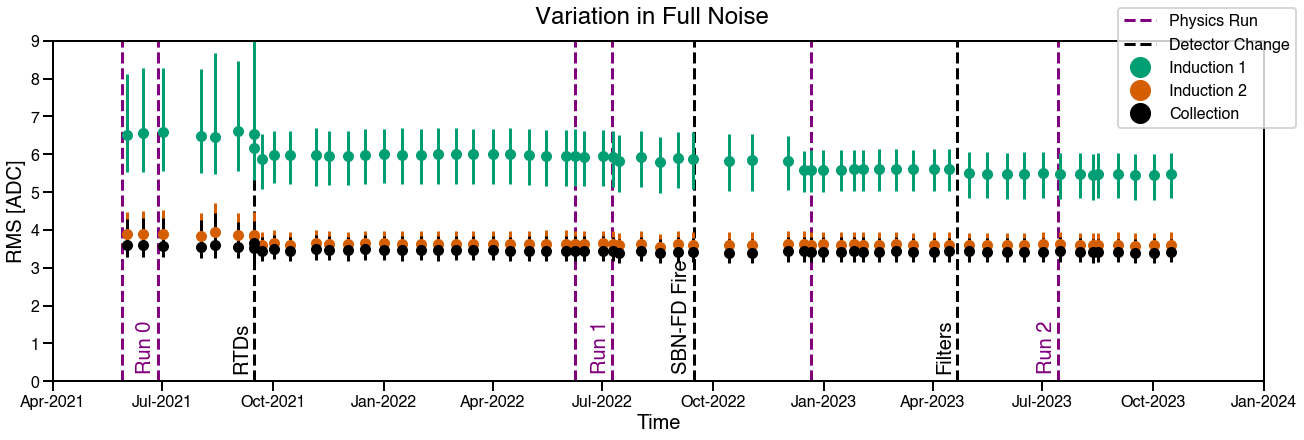

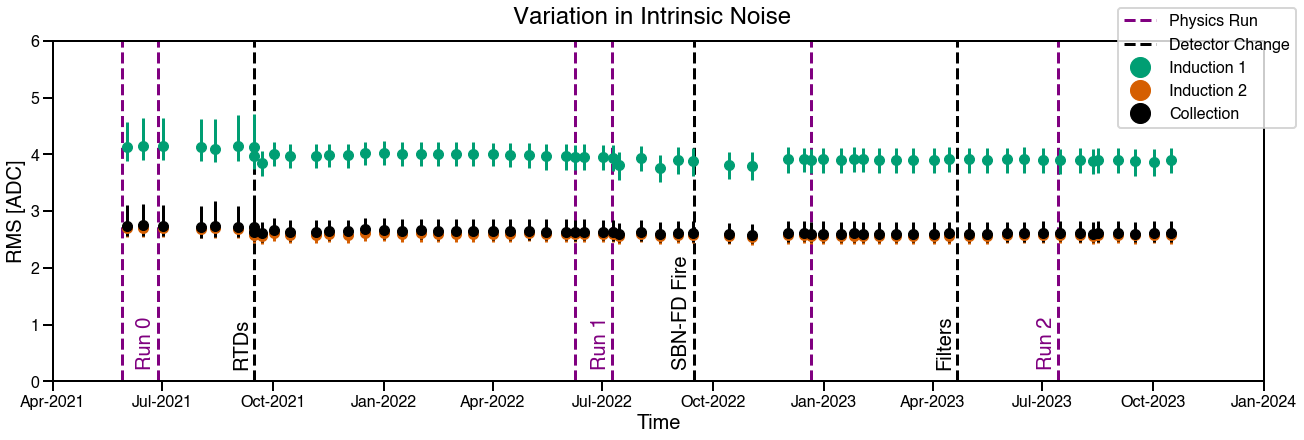

In [10]:
from tqdm import tqdm

def read_data(input_file) -> tuple[pd.DataFrame]:
    """
    Reads the noise data from the CSV and finds the median and one sigma
    values for each plane for both the raw and intrinsic noise.

    Parameters
    ----------
    input_file: str
        The full path of the input CSV.
    
    Return
    ------
    joint_frame: pd.DataFrame
        The median and one sigma values for the raw and intrinsic noise.
    """
    data = pd.read_csv(input_file)[['channel_id', 'raw_rms', 'int_rms', 'min_time', 'max_time']]
    if len(data > 0):
        min_time = data.iloc[0].min_time
        max_time = data.iloc[0].max_time
        data['plane'] = np.digitize(data['channel_id'] % 13824, [2304, 8064, 13824])
        grouped = data[['plane', 'raw_rms', 'int_rms']].groupby('plane')
        aggregate = [('median', lambda x: np.percentile(x, 50)),
                    ('low', lambda x: np.percentile(x, 50-(68.27/2))),
                    ('high', lambda x: np.percentile(x, 50+(68.27/2)))]
        metrics = grouped.aggregate(aggregate).to_numpy()
        raw, intrinsic = np.hsplit(metrics, 2)
        raw_frame = pd.DataFrame({'plane': np.arange(3, dtype='int'), 'raw_rms_median': raw[:,0], 'raw_rms_low': raw[:, 1], 'raw_rms_high': raw[:, 2]})
        int_frame = pd.DataFrame({'plane': np.arange(3, dtype='int'), 'int_rms_median': intrinsic[:,0], 'int_rms_low': intrinsic[:, 1], 'int_rms_high': intrinsic[:, 2]})
        joint_frame = raw_frame.merge(int_frame, on='plane')
        run = input_file.split('/')[-1].split('.')[0][3:8]
        joint_frame['run'] = int(run)
        joint_frame['time'] = datetime.fromtimestamp((min_time + max_time) // 2e9)
        return joint_frame
    else:
        return None
    
def annotate_plot(ax, time, annot_type, label, anchor=5.8):
    """
    Places an annotation on the axis with the specified time and
    label.

    Parameters
    ----------
    ax: matplotlib.pyplot.axis
        The axis to annotate.
    time: datetime.datetime
        The time to attach the annotation to.
    annot_type: str
        The type of annotation ('physics', 'hardware')
    label: str
        The label for the annotation.
    anchor: float
        The anchor position for the annotation.

    Returns
    -------
    None.
    """
    label_dt = timedelta(days=-18)
    color = {'physics': 'purple', 'hardware': 'black'}[annot_type]
    annot_label = {'physics': 'Physics Run', 'hardware': 'Detector Change'}[annot_type]
    plt.axvline(time, linestyle='--', c=color, label=annot_label)
    ax.text(time+label_dt, anchor, label, rotation=90, color=color,
            verticalalignment='bottom', fontsize=20)

def plot_history(metric, skip_list=[], normalize_last=False, annotations=None, save_path=None) -> None:
    """
    Plots the desired metric as a time series with error bars
    representing the 1-sigma boundaries of the data.

    Parameters
    ----------
    metric: str
        The name of the metric.
    skip_list: list[int]
        A list of run numbers to skip plotting.
    normalize_list: bool
        Boolean tag for normalizing all metrics to the central value
        of the last entry.
    annotations: dict
        The dictionary configuring the timestamps and labels
        associated with changes in the detector state.
    save_path: str
        The full path specifying the location to save the plot.

    Returns
    -------
    None.
    """
    plt.style.use('../plot_style.mplstyle')
    figure = plt.figure(figsize=(18,6))
    ax = figure.add_subplot()

    for k, v in annotations.items():
        annotate_plot(ax, v[0], v[1], k, 0.2)

    yerr_low = noise_data[f'{metric}_median'] - noise_data[f'{metric}_low']
    yerr_high = noise_data[f'{metric}_high'] - noise_data[f'{metric}_median']

    planes = ['Induction 1', 'Induction 2', 'Collection']
    for pi, p in enumerate(planes):
        mask = ((noise_data['plane'] == pi) & (~np.isin(noise_data['run'], skip_list)))
        xcv = noise_data['time'][mask].to_numpy()
        ycv = noise_data[f'{metric}_median'][mask].to_numpy()
        ylv = yerr_low[mask].to_numpy()
        yhv = yerr_high[mask].to_numpy()
        if normalize_last:
            last_index = np.argmax(xcv)
            ycv /= ycv[last_index]
            ylv /= ycv[last_index]
            yhv /= ycv[last_index]
        ax.errorbar(xcv, ycv, yerr=(ylv, yhv), fmt='o', markersize=10, label=p)

        #stability_mask = xcv > datetime(2022,12,20,17)
        print(f'{np.mean(ycv[-22:]):.3} +/- {np.std(ycv[-22:]) / np.mean(ycv[-22:]):.2%}')

    ax.set_xlabel('Time')
    ax.set_xlim(datetime(2021,4,1,0), datetime(2024,1,1,0))
    ax.set_ylim(0,2) if normalize_last else ax.set_ylim(0, 9 if metric == 'raw_rms' else 6)
    ax.set_ylabel('Normalized RMS') if normalize_last else ax.set_ylabel('RMS [ADC]')
    ax.xaxis.set_major_locator(md.MonthLocator(bymonth=(1,4,7,10)))
    ax.xaxis.set_major_formatter(md.DateFormatter('%b-%Y'))
    figure.suptitle('Variation in Full Noise' if metric == 'raw_rms' else 'Variation in Intrinsic Noise')
    h, l = plt.gca().get_legend_handles_labels()
    bl = dict(zip(l,h))
    figure.legend(bl.values(), bl.keys())
    if save_path is not None:
        figure.savefig(save_path)

annotations = {'': (datetime(2021,5,28,16), 'physics'),
               'Run 0': (datetime(2021,6,27,0), 'physics'),
               'RTDs': (datetime(2021,9,15,0,0), 'hardware'),
               ' ': (datetime(2022,6,8,4), 'physics'),
               'Run 1': (datetime(2022,7,9,8), 'physics'),
               'SBN-FD Fire': (datetime(2022,9,14,19), 'hardware'),
               '  ': (datetime(2022,12,20,17), 'physics'),
               'Filters': (datetime(2023,4,21,0,0), 'hardware'),
               'Run 2': (datetime(2023,7,14,8), 'physics')}
skip_list = [10265, 9762, 9747, 9394, 6738, 2087, 2088, 2093, 2094]

csv_files = glob('/Users/mueller/data/noise_epoch0_csv/run*.csv')
noise_data = [read_data(f) for f in csv_files]
noise_data = pd.concat([x for x in noise_data if x is not None])

plot_history('raw_rms', skip_list, False, annotations, save_path=f'{figure_path}noise/noise_history_full.pdf')
plot_history('int_rms', skip_list, False, annotations, save_path=f'{figure_path}noise/noise_history_intrinsic.pdf')

-0.52%
-1.51%
3.99%
0.12%
1.52%
0.79%


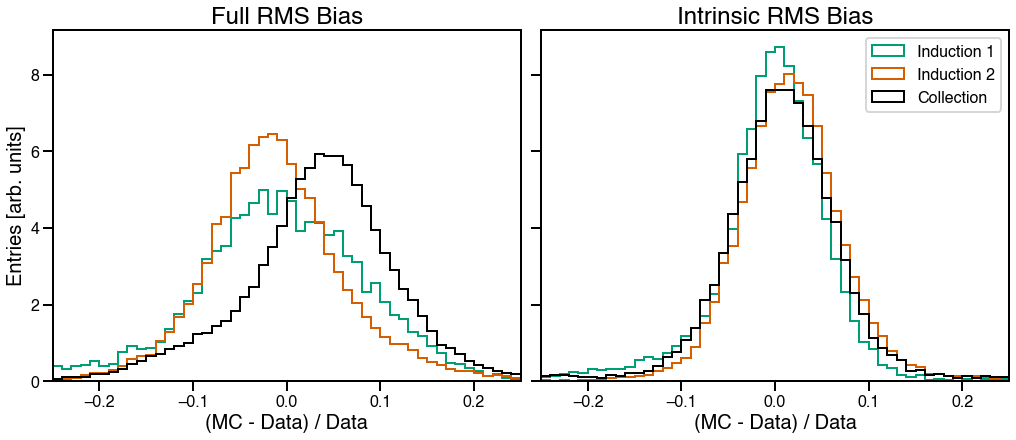

In [11]:
def plot_bias(data, montecarlo, metrics, save_path=None) -> None:
    """
    Plots the normalized difference (bias) between data and Monte Carlo
    datasets.

    Parameters
    ----------
    data: pd.DataFrame
        The median noise DataFrame (data).
    montecarlo: pd.DataFrame
        The median noise DataFrame (montecarlo).
    metric: list[str]
        The name of the metrics.
    save_path: str
        The full path specifying the location to save the plot.

    Returns
    -------
    None.
    """
    figure = plt.figure(figsize=(14,6))
    gspec = figure.add_gridspec(1,2)
    haxs = list()
    haxs.append(figure.add_subplot(gspec[0, 0]))
    haxs.append(figure.add_subplot(gspec[0, 1], sharey=haxs[0]))
    data_mc = data.merge(montecarlo, on='channel_id')

    for i in [0,1]:
        data_mc[f'bias_{metrics[i]}'] = (data_mc[f'{metrics[i]}_y'] - data_mc[f'{metrics[i]}_x']) / data_mc[f'{metrics[i]}_x']
        for pi, p in enumerate(['Induction 1', 'Induction 2', 'Collection']):
            mask = data_mc['plane_number_x'] == pi
            haxs[i].hist(data_mc.loc[mask][f'bias_{metrics[i]}'], bins=50, range=(-0.25, 0.25), histtype='step', label=p, density='normalize')
            haxs[i].set_xlabel('(MC - Data) / Data')
            haxs[i].set_xlim(-0.25, 0.25)
            print(f'{np.median(data_mc.loc[mask][f"bias_{metrics[i]}"]):.2%}')
    haxs[0].set_ylabel('Entries [arb. units]')
    haxs[1].tick_params(labelleft=False)
    haxs[1].legend()
    haxs[0].set_title('Full RMS Bias')
    haxs[1].set_title('Intrinsic RMS Bias')
    if save_path is not None:
        figure.savefig(save_path)

plot_bias(data.median_noise_data, montecarlo.median_noise_data, ['raw_rms', 'int_rms'], save_path=f'{figure_path}noise/bias_noise.pdf')

0.160, 0.141
0.373, 0.140
0.105, 0.100
0.177, 0.099


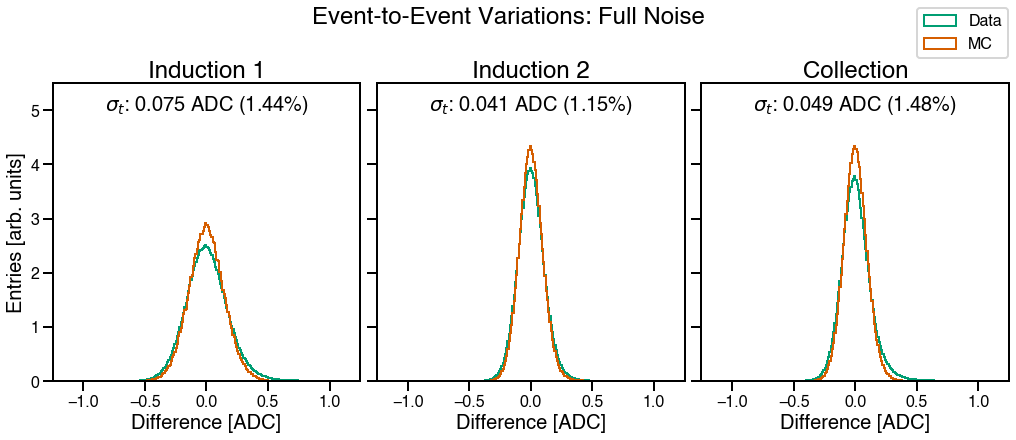

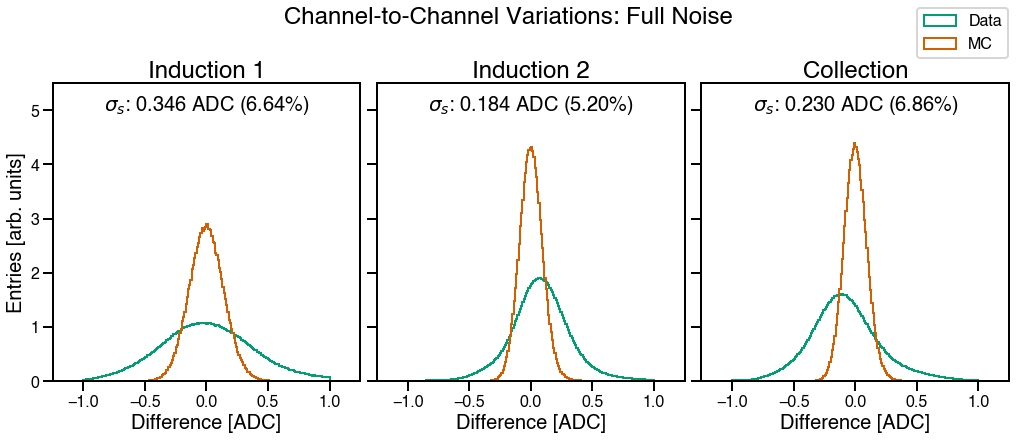

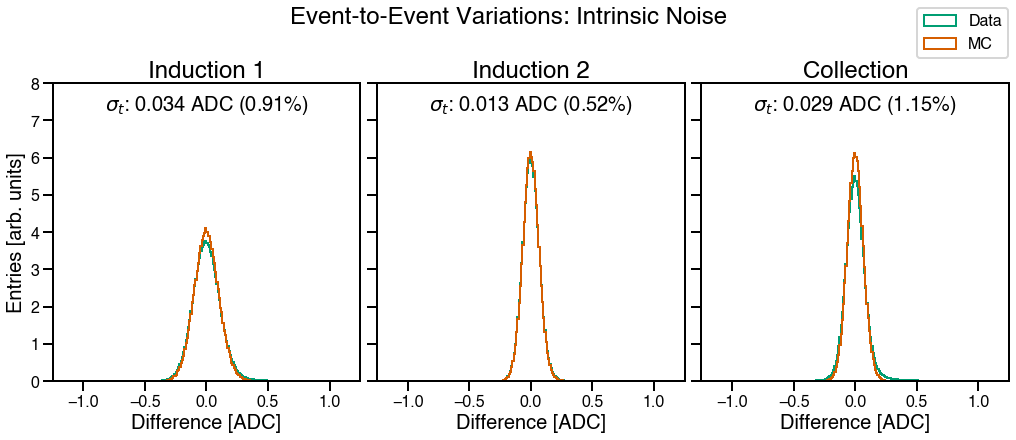

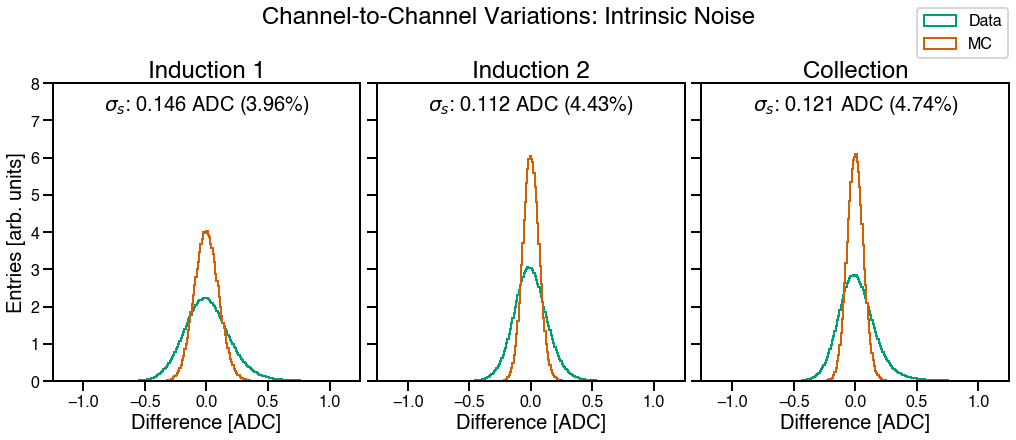

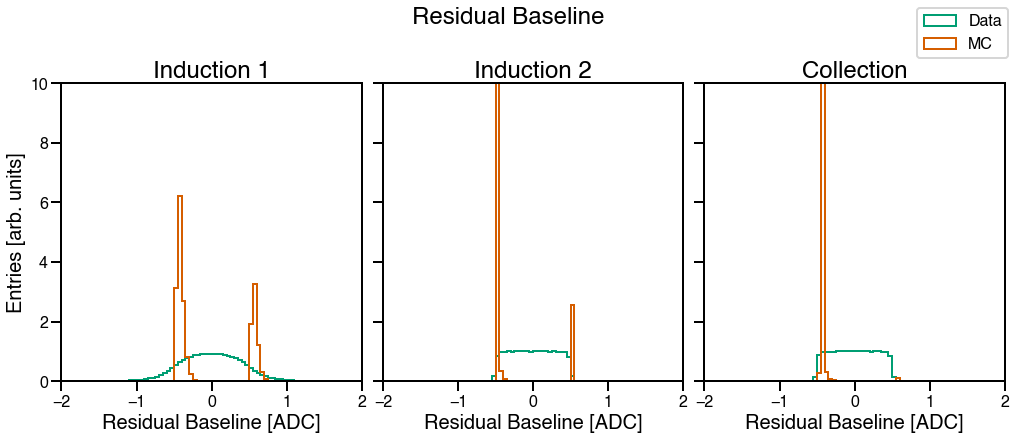

In [12]:
from scipy.optimize import curve_fit

def gaus(x, amplitude, mean, sigma) -> np.array:
    """
    Implements a simple Gaussian distribution for fitting.

    Parameters
    ----------
    x: np.array
        The array of the independent variable.
    amplitude: float
        The scalar normalization coefficient.
    mean: float
        The mean value of the distribution.
    sigma: float
        The width of the distribution.
    """
    return amplitude * (1.0/(sigma * np.sqrt(6.2831853))) * np.exp(-0.5 * ((x - mean) / sigma)**2)

def fit_distribution(counts, centers) -> list[float]:
    """
    Fits a Gaussian to the input distribution.

    Parameters
    ----------
    counts: np.array
        The counts associated with each bin.
    centers: np.array
        The centers associated with each bin.
    
    Returns
    -------
    fit_results: list[float]
        A list of the best fit parameters and associated errors.
    """
    popt, pcov = curve_fit(gaus, centers, counts, p0=[np.max(counts), 0, 0.3])
    perr = np.sqrt(np.diag(pcov))
    fit_results = np.concatenate([popt, perr]).tolist()
    return fit_results

def smear_distribution(counts, centers, sf) -> np.array:
    """
    Calculates the convolution of the input distribution with the
    Gaussian smearing function described by the smearing factor.

    counts: np.array
        The array of bin counts for the MC distribution.
    centers: np.array
        The array of bin centers for the MC distribution.
    sf: float
        The width (sigma) parameter of the Gaussian smearing
        function.

    Returns
    -------
    convolution: np.array
        The resulting convolution of the input distribution and the
        Gaussian smearing function.
    """
    gaus_smear = gaus(centers, (1.0 / (sf * np.sqrt(6.2831853))), 0, sf)
    covolution = np.convolve(counts, gaus_smear, mode='same')
    return covolution

def plot_comparison_smearing(data, montecarlo, metric, vtype, ymax=5.5, save_path=None) -> None:
    """
    Produces a plot of the distribution of the specified metric
    in data and MC for each plane and calculates the Gaussian
    smearing width necessary to bring MC into alignment with data.

    Parameters
    ----------
    data: pd.DataFrame
        The DataFrame containing the data metrics.
    montecarlo: pd.DataFrame
        The DataFrame containing the MC metrics.
    metric: str
        The name of the metric.
    vtype: str
        The type of variation (e2e, c2c).
    ymax: float
        The common maximum of the y-axis.
    save_path: str
        The full path specifying the location to save the plot.

    Returns
    -------
    None.
    """
    planes = ['Induction 1', 'Induction 2', 'Collection']
    all_counts, all_centers = list(), list()
    fit_results, smear_factors = list(), list()
    convolutions = list()
    medians = list()
    full_metric = f'{metric}_{vtype}abs'
    metric_type = 'Full' if 'raw' in metric else 'Intrinsic'
    for pi in range(3):
        # Data
        mask = data.get_mask(full_metric, plane=pi, wired_only=True, tpc=2)
        mask = mask | data.get_mask(full_metric, plane=pi, wired_only=True, tpc=3)
        style = data.get_styling(full_metric)
        counts, edges = np.histogram(data[full_metric][mask], bins=200, range=(-1.0, 1.0))
        max_bin = np.argmax(counts)
        counts[max_bin] = (counts[max_bin-1] + counts[max_bin+1])/2.0
        centers = (edges[1:] + edges[:-1]) / 2.0
        all_counts.append(counts)
        all_centers.append(centers)
        fit_results.append(fit_distribution(counts, centers))
        medians.append(np.median(data[metric][mask]))

        # Monte Carlo
        mask = montecarlo.get_mask(full_metric, plane=pi, wired_only=True)
        style = montecarlo.get_styling(full_metric)
        counts, edges = np.histogram(montecarlo[full_metric][mask], bins=200, range=(-1.0, 1.0))
        max_bin = np.argmax(counts)
        counts[max_bin] = (counts[max_bin-1] + counts[max_bin+1])/2.0
        centers = (edges[1:] + edges[:-1]) / 2.0
        all_counts.append(counts)
        all_centers.append(centers)
        fit_results.append(fit_distribution(counts, centers))

        if pi == 0:
            print(f'{fit_results[-2][2]:.3f}, {fit_results[-1][2]:.3f}')
        smear_factors.append(np.sqrt(np.square(fit_results[-2][2]) - np.square(fit_results[-1][2])))
        convolutions.append(smear_distribution(counts, centers, smear_factors[-1]))
    
    plot_triplet(all_counts, all_centers, labels=['Data', 'MC'], vtype=vtype, sigma=smear_factors, medians=medians, ymax=ymax, mtype=metric_type, save_path=save_path)
    #conv_counts = [x for j in [[all_counts[2*i], convolutions[i]] for i in range(3)] for x in j]
    #plot_triplet(conv_counts, all_centers, labels=['Data', 'Smeared MC'], vtype=vtype, ymax=ymax, mtype=metric_type)


def plot_baseline(data, montecarlo, ymax=10) -> None:
    """
    Produces a plot of the distribution of the baseline.

    Parameters
    ----------
    data: pd.DataFrame
        The DataFrame containing the data metrics.
    montecarlo: pd.DataFrame
        The DataFrame containing the MC metrics.
    ymax: float
        The common maximum of the y-axis.

    Returns
    -------
    None.
    """
    figure = plt.figure(figsize=(14,6))
    gspec = figure.add_gridspec(1,3)
    haxs = [figure.add_subplot(gspec[0, 0]),]
    haxs.extend([figure.add_subplot(gspec[0, p], sharey=haxs[0]) for p in [1,2]])
    planes = ['Induction 1', 'Induction 2', 'Collection']
    style = ['Baseline [ADC]', (-5, 5), 200]
    kws = {'histtype': 'step', 'density': 'norm', 'range': style[1], 'bins': style[2]}
    labels=['Data', 'MC']
    for pi, p in enumerate(planes):
        # Data
        mask = data.get_mask('!pedestal', plane=pi, wired_only=True)
        haxs[pi].hist(data['!pedestal'][mask], label=labels[0], **kws)
        
        # Monte Carlo
        mask = montecarlo.get_mask('!pedestal', plane=pi, wired_only=True)
        haxs[pi].hist(montecarlo['!pedestal'][mask], label=labels[1], **kws)

        haxs[pi].set_xlim(-2, 2)
        haxs[pi].set_xlabel('Residual Baseline [ADC]')
        haxs[pi].set_title(p)
        if pi > 0: haxs[pi].tick_params(labelleft=False)
    
    haxs[0].set_ylabel('Entries [arb. units]')
    haxs[0].set_ylim(0.0, ymax)

    h, l = plt.gca().get_legend_handles_labels()
    bl = dict(zip(l,h))
    figure.suptitle('Residual Baseline\n')
    figure.legend(bl.values(), bl.keys())

def plot_triplet(counts, centers, labels, vtype, sigma=None, medians=None, ymax=5.5, mtype='Full', save_path=None) -> None:
    """
    Plots a three-plane view using the input binned data.

    Parameters
    ----------
    counts: list[np.array]
        The list of arrays containing the counts for each plane/distribution.
    centers: list[np.array]
        The list of arrays containing the centers for each plane/distribution.
    labels: list[str]
        The list of strings that label the two datasets.
    vtype: str
        The type of variation (e2e, c2c).
    sigma: list[float]
        The sigma parameters of the Gaussian smearing for each plane.
    medians: list[float]
        The median value of the parent metric in data for each plane.
    ymax: float
        The common maximum of the y-axis.
    mtype: str
        The type of metric to be used in the plot title.
    save_path: str
        The full path specifying the location to save the plot.
        
    Returns
    -------
    None.
    """
    figure = plt.figure(figsize=(14,6))
    gspec = figure.add_gridspec(1,3)
    haxs = [figure.add_subplot(gspec[0, 0]),]
    haxs.extend([figure.add_subplot(gspec[0, p], sharey=haxs[0]) for p in [1,2]])
    planes = ['Induction 1', 'Induction 2', 'Collection']
    kws = {'histtype': 'step', 'density': 'norm', 'range': (-1.0, 1.0), 'bins': 200}
    for pi, p in enumerate(planes):
        haxs[pi].hist(centers[2*pi], weights=counts[2*pi], label=labels[0], **kws)
        haxs[pi].hist(centers[2*pi+1], weights=counts[2*pi+1], label=labels[1], **kws)

        haxs[pi].set_xlim(-1.25, 1.25)
        haxs[pi].set_xlabel('Difference [ADC]')
        haxs[pi].set_title(p)
        if pi > 0: haxs[pi].tick_params(labelleft=False)

        if sigma is not None:
            s = r'$\sigma_t$' if vtype == 'e2e' else r'$\sigma_s$'
            haxs[pi].text(0.5, 0.97, f'{s}: {sigma[pi]:.3f} ADC ({sigma[pi] / medians[pi]:.2%})',
                        transform=haxs[pi].transAxes, verticalalignment='top',
                        horizontalalignment='center', size=20)
    
    haxs[0].set_ylabel('Entries [arb. units]')
    haxs[0].set_ylim(0.0, ymax)

    h, l = plt.gca().get_legend_handles_labels()
    bl = dict(zip(l,h))
    title = {'e2e': 'Event-to-Event Variations' + f': {mtype} Noise\n',
             'c2c': 'Channel-to-Channel Variations' + f': {mtype} Noise\n',
             'baseline': 'Baseline\n'}[vtype]
    figure.suptitle(title)
    figure.legend(bl.values(), bl.keys())
    if save_path is not None:
        figure.savefig(save_path)

plt.style.use('../plot_style.mplstyle')
plot_comparison_smearing(data, montecarlo, '!raw_rms', vtype='e2e', ymax=5.50, save_path=f'{figure_path}noise/e2e_comparison_full.pdf')
plot_comparison_smearing(data, montecarlo, '!raw_rms', vtype='c2c', ymax=5.50, save_path=f'{figure_path}noise/c2c_comparison_full.pdf')
plot_comparison_smearing(data, montecarlo, '!int_rms', vtype='e2e', ymax=8.00, save_path=f'{figure_path}noise/e2e_comparison_intrinsic.pdf')
plot_comparison_smearing(data, montecarlo, '!int_rms', vtype='c2c', ymax=8.00, save_path=f'{figure_path}noise/c2c_comparison_intrinsic.pdf')
plot_baseline(data, montecarlo, ymax=10)

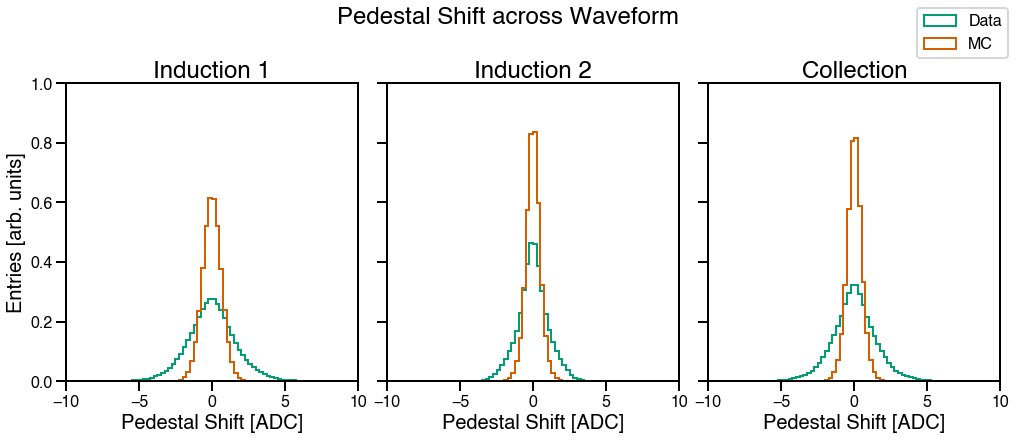

In [13]:
def plot_pedestal_offset(data, montecarlo, ymax=10) -> None:
    """
    Produces a plot of the distribution of the pedestal
    offset between the first 512 time ticks and the last
    512 time ticks.

    Parameters
    ----------
    data: pd.DataFrame
        The DataFrame containing the data metrics.
    montecarlo: pd.DataFrame
        The DataFrame containing the MC metrics.
    ymax: float
        The common maximum of the y-axis.

    Returns
    -------
    None.
    """
    figure = plt.figure(figsize=(14,6))
    gspec = figure.add_gridspec(1,3)
    haxs = [figure.add_subplot(gspec[0, 0]),]
    haxs.extend([figure.add_subplot(gspec[0, p], sharey=haxs[0]) for p in [1,2]])
    planes = ['Induction 1', 'Induction 2', 'Collection']
    style = ['Baseline [ADC]', (-25, 25), 200]
    kws = {'histtype': 'step', 'density': 'norm', 'range': style[1], 'bins': style[2]}
    labels=['Data', 'MC']
    for pi, p in enumerate(planes):
        # Data
        mask = data.get_mask('!p0', plane=pi, wired_only=True)
        haxs[pi].hist(data['!p0'][mask] - data['!p3'][mask], label=labels[0], **kws)
        
        # Monte Carlo
        mask = montecarlo.get_mask('!p0', plane=pi, wired_only=True)
        haxs[pi].hist(montecarlo['!p0'][mask] - montecarlo['!p3'][mask], label=labels[1], **kws)

        haxs[pi].set_xlim(-10, 10)
        haxs[pi].set_xlabel('Pedestal Shift [ADC]')
        haxs[pi].set_title(p)
        if pi > 0: haxs[pi].tick_params(labelleft=False)
    
    haxs[0].set_ylabel('Entries [arb. units]')
    haxs[0].set_ylim(0.0, ymax)

    h, l = plt.gca().get_legend_handles_labels()
    bl = dict(zip(l,h))
    figure.suptitle('Pedestal Shift across Waveform\n')
    figure.legend(bl.values(), bl.keys())

plt.style.use('../plot_style.mplstyle')
plot_pedestal_offset(data, montecarlo, ymax=1)

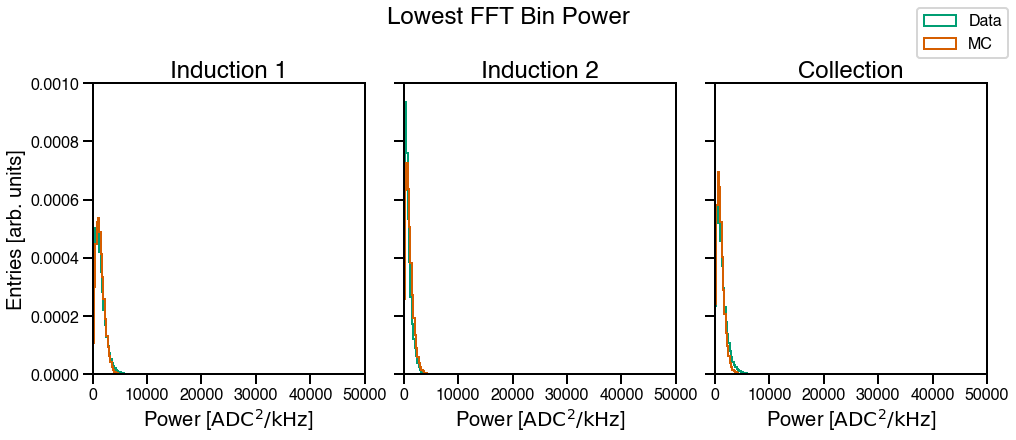

In [14]:
def plot_fft_lowbin(data, montecarlo, ymax=10) -> None:
    """
    Produces a plot of the distribution of the lowest fft
    bin content in data and montecarlo

    Parameters
    ----------
    data: pd.DataFrame
        The DataFrame containing the data metrics.
    montecarlo: pd.DataFrame
        The DataFrame containing the MC metrics.
    ymax: float
        The common maximum of the y-axis.

    Returns
    -------
    None.
    """
    figure = plt.figure(figsize=(14,6))
    gspec = figure.add_gridspec(1,3)
    haxs = [figure.add_subplot(gspec[0, 0]),]
    haxs.extend([figure.add_subplot(gspec[0, p], sharey=haxs[0]) for p in [1,2]])
    planes = ['Induction 1', 'Induction 2', 'Collection']
    style = ['Baseline [ADC]', (0, 50000), 200]
    kws = {'histtype': 'step', 'density': 'norm', 'range': style[1], 'bins': style[2]}
    labels=['Data', 'MC']
    for pi, p in enumerate(planes):
        # Data
        mask = data.get_mask('!fft_bin0', plane=pi, wired_only=True)
        haxs[pi].hist(data['!fft_bin0'][mask], label=labels[0], **kws)
        
        # Monte Carlo
        mask = montecarlo.get_mask('!fft_bin0', plane=pi, wired_only=True)
        haxs[pi].hist(montecarlo['!fft_bin0'][mask], label=labels[1], **kws)

        haxs[pi].set_xlim(0, 50000)
        haxs[pi].set_xlabel('Power [$\mathrm{ADC}^2/\mathrm{kHz}$]')
        haxs[pi].set_title(p)
        if pi > 0: haxs[pi].tick_params(labelleft=False)
    
    haxs[0].set_ylabel('Entries [arb. units]')
    haxs[0].set_ylim(0.0, ymax)

    h, l = plt.gca().get_legend_handles_labels()
    bl = dict(zip(l,h))
    figure.suptitle('Lowest FFT Bin Power\n')
    figure.legend(bl.values(), bl.keys())

plot_fft_lowbin(data, montecarlo, ymax=0.001)

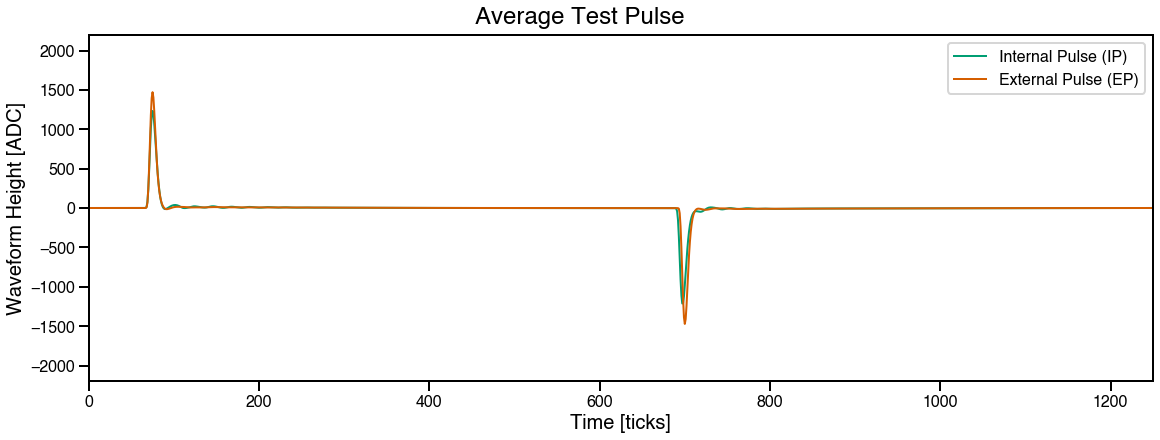

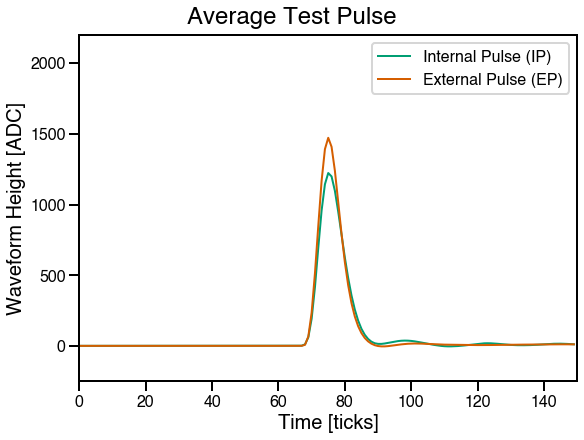

In [15]:
import uproot

def plot_average_waveform_artdaq(path, labels, title, channel=0, scale=2200, save_path=None):
    """
    Plots the average waveform for the specified channel using a ROOT
    file prepared by the TPCTestPulseArtDAQ module. This module aligns
    waveforms and stores them (as a sum) in a TH2I with a set of bins
    for each channel.

    Parameters
    ----------
    path: list[str]
        The base path to the input ROOT files.
    labels: list[str]
        The labels for each plot element.
    title: str
        The title to place on the plot.
    channel: int
        The channel number to retrieve and plot.
    scale: float
        The y-range of the plot. The range will be set to (-scale, scale).
    save_path: str
        The full path specifying the location to save the plot.
    """
    plt.style.use('../plot_style.mplstyle')
    
    figure = plt.figure(figsize=(16,6))
    ax = figure.add_subplot()
    
    for pi, p in enumerate(path):
        data = uproot.open(p)['tpctestpulseartdaq/output'].values()
        waveform, count = data[:-1, channel].astype(float), data[-1, channel]
        waveform -= np.median(waveform)
        waveform /= count
        ax.plot(np.arange(len(waveform)), waveform, linestyle='-', linewidth=2, label=labels[pi])
    ax.set_xlim(0, len(waveform))
    ax.set_ylim(-scale, scale)
    ax.set_xlabel('Time [ticks]')
    ax.set_ylabel('Waveform Height [ADC]')
    ax.legend()
    figure.suptitle(title)
    if save_path is not None:
        figure.savefig(save_path)

def plot_average_pulse_artdaq(path, labels, title, channel=0, scale=2200, save_path=None):
    """
    Plots the average waveform for the specified channel using a ROOT
    file prepared by the TPCTestPulseArtDAQ module. This module aligns
    waveforms and stores them (as a sum) in a TH2I with a set of bins
    for each channel.

    Parameters
    ----------
    path: list[str]
        The base path to the input ROOT files.
    labels: list[str]
        The labels for each plot element.
    title: str
        The title to place on the plot.
    channel: int
        The channel number to retrieve and plot.
    scale: float
        The y-range of the plot. The range will be set to (-250, scale).
    save_path: str
        The full path specifying the location to save the plot.
    """
    plt.style.use('../plot_style.mplstyle')
    
    figure = plt.figure(figsize=(8,6))
    ax = figure.add_subplot()
    
    for pi, p in enumerate(path):
        data = uproot.open(p)['tpctestpulseartdaq/output'].values()
        waveform, count = data[:-1, channel].astype(float), data[-1,channel]
        waveform -= np.median(waveform)
        waveform /= count

        pwaveform = waveform[:150]
        mpeak = np.argmin(waveform)
        mwaveform = -1 * waveform[mpeak-75:mpeak+75]
        awaveform = (pwaveform + mwaveform) / 2.0
        ax.plot(np.arange(150), awaveform, linestyle='-', linewidth=2, label=labels[pi])
    
    ax.set_xlim(0, 150)
    ax.set_ylim(-250, scale)
    ax.set_xlabel('Time [ticks]')
    ax.set_ylabel('Waveform Height [ADC]')
    ax.legend()
    figure.suptitle(title)
    if save_path is not None:
        figure.savefig(save_path)

sources = ['/Users/mueller/data/test_pulse/run10487.root', '/Users/mueller/data/test_pulse/waveforms_conn12_inphase.root']
plot_average_waveform_artdaq(sources, ['Internal Pulse (IP)', 'External Pulse (EP)'], title='Average Test Pulse', channel=32225, save_path=f'{figure_path}testpulse/tp_waveform.pdf')
plot_average_pulse_artdaq(sources, ['Internal Pulse (IP)', 'External Pulse (EP)'], title='Average Test Pulse', channel=32225, save_path=f'{figure_path}testpulse/tp_pulse.pdf')